In [110]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

df = pd.read_csv('cleaned_data.csv')
sns.set_palette("ch:2.5,-.2,dark=50")

## Questions and Assumptions

We wanted to produce an analysis of the King Country Property Sales Data that would be useful to a number of people throughout the process of valuating a house. We will ask ourselves three different questions about the dataset based on data that homeowners, estate agents, and surveyors might have access to respectively. (As a secondary goal of our analysis, there are a number of guidelines from housing associations as to how various housing metrics affect house prices; we wanted to use these as a baseline and see whether our modelling could beat these coarse guidelines.)

Questions:
1. What is the relationship between basic size and quantity metrics and the price of a house? 
    * We imagined a homeowner coming to the estate agent with basic statistics about their house, and the estate agent being able to use our model in order to give them a decent prediction of how these metrics would affect their house price.
    * During our analysis we found that, for example the square footage of the property displayed too great a colinearity with the number of bedrooms for the two to be included as features in the same model. We had to look at these metrics individually in order to decide which was the more reliable for creating a model to predict house price. We do this with a pair plot between the size variables. 
    * We also tried a combination of the two of these features, square foot per bedroom to see if the relationship between the two was any more or less valid a model.

2. How much money could a homeowner get for their home if they spend the money to improve either its grade or condition?
    - We imagined a homeowner employing a surveyor to grade their house, and the surveyor being able to tell them whether it is worth it to spend the money on making the necessary improvements to move up a grade.
    - There are obvious caveats here, such as whether the spending will definitely guarantee an increase in the grading, but this certainty is also something that the model can give us some idea of.

3. Does recent renovation affect house prices?
    - If you have recently renovated your house, should you stay in it or sell it? (Much like the TV show Stay or Sell)
    - There are some major considerations with this question. If older houses are more expensive than newer ones in general, then a house that was renovated 60 years ago might be more expensive than a house built 10 years ago that has been recently renovated. 
    - This is limited by the fact that we don't know how much the renovation costs, but we hope to be able to give a general impression of whether it is worth it. 
    - We assume that a value of 0 for `yr_renovated` signifies that the property has not been renovated.

## Cleaning

#### NaN Values

In our cleaning we found that there were a number of missing values for the `waterfront` and `yr_renovated` variables. `waterfront` is a binary variable diplaying either a `1` or a `0` to show whether or not the property is on the waterfront. We decided that although the King Country area is by the sea, only a select few properties are right on the waterfront. For this reason it was easiest to assume that `nan` values for `waterfront` were not by the waterfront and therefor assign them `0`.

There were also a considerable amount of `nan` values for `yr_renovated`. In our analysis we are only going to be using using `yr_renovated` where there is a value for `yr_renovated` greater than 0, and we won't be dealing with, for example, median values of `yr_renovated` on its own. 

#### Dates

We also knew that we would want to use dates to see how prices change over time, but more importantly to see how long ago houses were renovated by subtracting the `yr_renovated` from the year in the `date` column. The formatting of the date as it was was not particularly robust as the date strings were different lengths (e.g. September is represented as _9_ not _09_). We converted the dates with pandas' built-in `parse_dates` argument for `read_csv`. 

#### Scaling

>_"When in doubt, take the log!"_ - Dan Sanz Berecill

With this being a sizeable dataset, with very large values for variables such as price, it seemed appropriate to take logarithms of some of our variables in order scale our data to make it more manageable. More importantly 'taking the log' will ensure that our input data has a normal distribution so that we have a greater chance of outputting normally distributed residuals from our model.

## Exploratory Data Analysis and Visualisation

The most effective way to predict the price of a property is by its size. It seems obvious that a bigger property is more expensive, but with linear regression we hope to be able to give an accurate description of the relationship between the two. In order to do this we need to consider the following:

- Which of the variables for size will make the best dependent variable with which to predict price?
- If we decide to add another feature and make our regression model multivariate, which feature will support the model best. Most features run the risk of multicolinearity.

#### Correlation, correlation, correlation

First of all lets have a look at a heatmap for price versus all of the other variables.

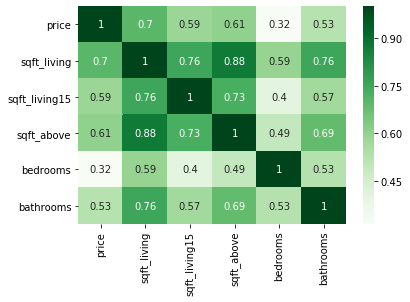

In [89]:
# First we make a new dataframe that of the pearson coefficient of each size variable and price against each other.
correlation_matrix = df[['price','sqft_living', 'sqft_living15','sqft_above', 'bedrooms', 'bathrooms']].corr(method='pearson')
# Then we use seaboard's heatmap to display this information
sns.heatmap(correlation_matrix, cmap='Greens', annot=True)

The size metric which has the strongest correlation with price is the square footage of the living space, with a **Pearson Coefficient** of over 0.7. At a glance we can also see that `sqft_living` and `sqft_above` correlate very strongly with each other, meaning we won't be able to use both features in a multivariate regression without the danger of multicolinearity. 

#### The search for the second feature

If we want to see which second feature will fit well into our model we can't just look at the Pearson Coefficient between those two features, there is more to look at. This is where a **Pair Plot** will come in handy.

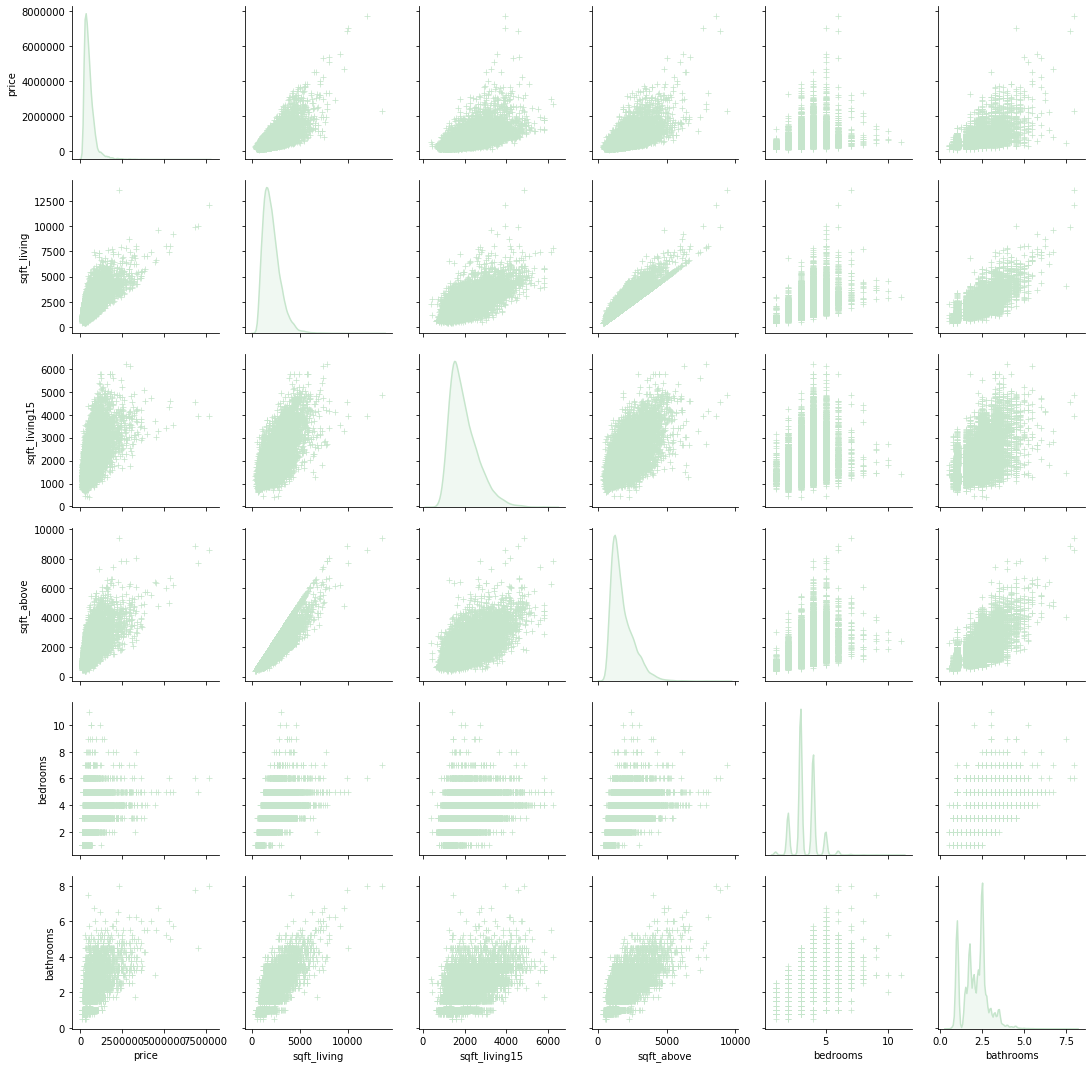

In [112]:
size_df = df[['price','sqft_living', 'sqft_living15','sqft_above', 'bedrooms', 'bathrooms']]
sns.pairplot(size_df, diag_kind="kde", markers="+")

We want a second feature that correlates strongly with `price` but that doesn't correlate as strongly with `sqft_living`. The most obvious candidate for this is the `sqft_living15` or the square footage of the nearest fifteen properties to the property observed. Both of these desired properties. 

#### Log Time!

As price and square footage are both large units and are difficult to compare in scale, taking the log at this point will normalise these two variables. Lets look at the distribution before and after applying a logarithm to these variables.

Text(0.5, 1.0, 'Square Footage of Living Space')

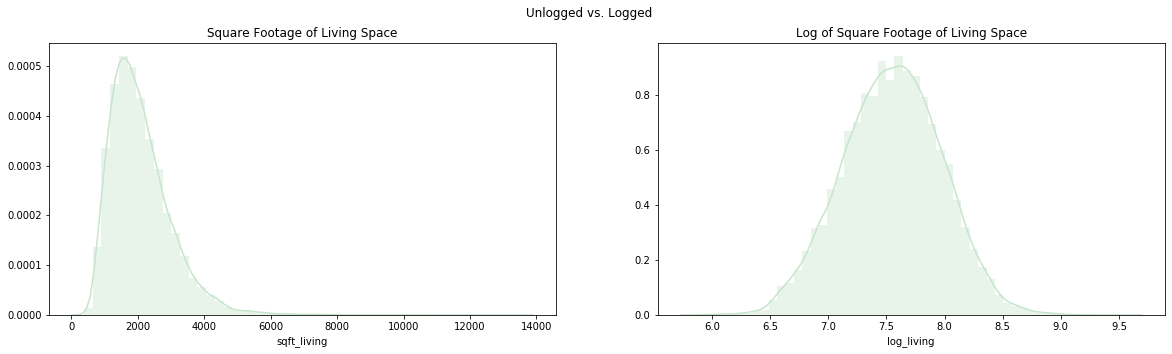

In [111]:
size_df['log_living'] = size_df['sqft_living'].map(lambda x: np.log(x)) #This logs all of the values for 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
sns.distplot(size_df['log_living'], ax=ax2).set_title('Log of Square Footage of Living Space')
plt.suptitle('Unlogged vs. Logged')
sns.distplot(size_df['sqft_living'], ax=ax1).set_title('Square Footage of Living Space')

The data for square footage of living space on its own has a strong positive skew. After applying a logarithm we see that the data is far more normally distributed.